Library

In [85]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

import file

In [86]:
def pathProcessing (path):
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.gif']  # Add more extensions if needed
    image_paths = []

    for ext in image_extensions:
        image_paths.extend(glob.glob(os.path.join(path, ext)))

    return image_paths

Read Image

In [87]:
def readImage (paths):
    images=[]

    for path in paths:
        image= cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        if image is not None:
            images.append(image)
        else:
            print(f"Failed to read image at path: {path}")

    return images

In [88]:
def show_images(images, num_cols=3):
    num_images = len(images)
    num_rows = (num_images + num_cols - 1) // num_cols

    plt.figure(figsize=(10, 8))  # Atur ukuran figur sesuai kebutuhan

    for i, image in enumerate(images, 1):
        plt.subplot(num_rows, num_cols, i)
        plt.imshow(image, cmap='gray')  # Menggunakan cmap='gray' jika gambar dalam mode grayscale
        plt.axis('off')

    plt.tight_layout()
    plt.show()

PreProcessing

In [89]:
def gaussianBlur(images):
    blurredImages=[]
    for image in images:
        kernel_size = (5, 5)
        sigma_x = 0
        blurredImage = cv2.GaussianBlur(image, kernel_size, sigma_x)
        blurredImages.append(blurredImage)
    
    return blurredImages       

In [90]:
def histogramEqualizing(images):
    equalizedImages=[]
    for image in images:
        equalizedImage = cv2.equalizeHist(image)
        equalizedImages.append(equalizedImage)
    
    return equalizedImages

In [91]:
def bitwiseNot(images):
    flippedImage=[]
    for image in images :
        bitwise_not_image = cv2.bitwise_not(image)
        flippedImage.append(bitwise_not_image)
    return flippedImage

In [92]:
def contourDetect(images):
    cleanImages = []
    for image in images:
        contours,  hierarchy= cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

        # Gambar kontur pada gambar asli
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            ras = format(w / h, '.2f')
            if h >= 40 and w >= 10 and float(ras) <= 1:
                cv2.rectangle(image, (x, y), (x + w, y + h), (255), thickness=10)
            elif h >= 10 and w >= 5 and float(ras) <= 1:
                cv2.rectangle(image, (x, y), (x + w, y + h), (255), thickness=10)
        cleanImages.append(image)
    return cleanImages


In [93]:
def erode(images):

    erodedImages=[]
    for image in images:
        kernel = (5, 5)
        erodedImage  = cv2.erode(image, kernel, iterations=1)
        erodedImages.append(erodedImage)
    
    return erodedImages  

In [94]:
def laplacianEdgeDetect(images):
    edgeDetected=[]
    for image in images :
        laplacian = cv2.Laplacian(image, cv2.CV_64F)
        edgeDetected.append(laplacian)
    
    return edgeDetected

In [95]:
def sobelEdgeDetect(images):
    edgeDetected=[]
    for image in images :
        normalizedImage = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        sobel_x = cv2.Sobel(normalizedImage, cv2.CV_64F, 1, 0, ksize=5)
        sobel_y = cv2.Sobel(normalizedImage, cv2.CV_64F, 0, 1, ksize=5)
        sobelCombined = cv2.magnitude(sobel_x, sobel_y)
        edgeDetected.append(sobelCombined)
    return sobelCombined

In [96]:
def adaptiveThresholding(images):
    thresholded=[]
    for image in images:
        normalizedImage = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        adaptiveThreshold = cv2.adaptiveThreshold(normalizedImage, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
        thresholded.append(adaptiveThreshold)
    return thresholded

In [97]:
def otsuThresholding(images):
    thresholded=[]
    for image in images:
        normalizedImage = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        ret, otsu_threshold = cv2.threshold(normalizedImage, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        thresholded.append(otsu_threshold)
    return thresholded

In [98]:
import cv2

def matchFeature(images, templates, threshold=0.8):
    matched_regions = []

    for image in images:
        found= False
        for template in templates:
            if found == False:
                h, w = template.shape[:2]
                if h > image.shape[0] or w > image.shape[1]:
                    # Ubah ukuran template jika ukuran template melebihi ukuran gambar
                    template = cv2.resize(template, (image.shape[1], image.shape[0]))

                result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF)
                min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
                if max_val >= threshold:
                    # Lakukan tindakan jika kecocokan melewati ambang tertentu
                    found = True
                # Lakukan pembandingan nilai untuk menentukan kecocokan
                if max_val >= threshold:
                    top_left = max_loc
                    bottom_right = (top_left[0] + w, top_left[1] + h)
                    cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
            else:
                break
        matched_regions.append(image)

    return matched_regions


In [99]:
def main ():

    featurePath= 'feature'
    
    featuresPath=pathProcessing(featurePath)
    features=readImage(featuresPath)

    #preprocessing
    features= gaussianBlur(features)
    features= otsuThresholding(features)

    folderPath= 'KTP'

    paths=pathProcessing(folderPath)
    images= readImage(paths)

    images= gaussianBlur(images)
    images= gaussianBlur(images)
    images= gaussianBlur(images)
    images= erode(images)

    #lokalisasi
    images= contourDetect(images)

    #segmentasi
    edges=laplacianEdgeDetect(images)
    thresholded= otsuThresholding(edges)

    flipped= bitwiseNot(thresholded)
    #pengenalan
    matched=matchFeature(flipped,features)

    show_images(matched)
    return features

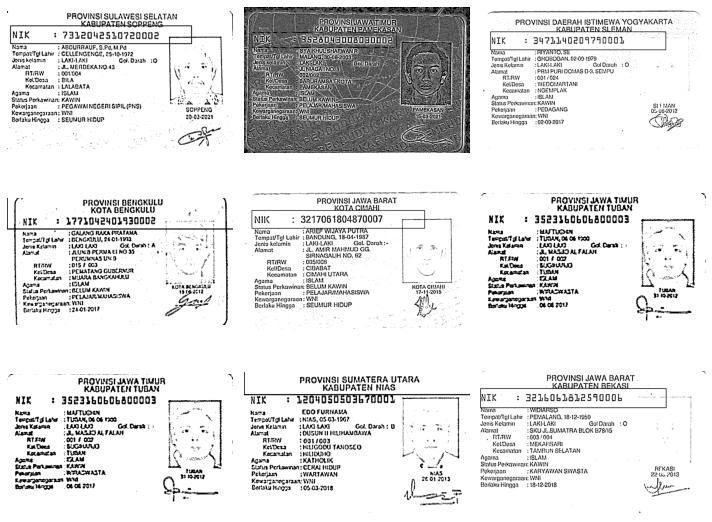

In [100]:
images= main()